<a href="https://colab.research.google.com/github/vamado09/Applied-Data-Science/blob/main/HW2_VicenteDeLeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vicente De Leon

IU_id: 2001014594

APPLIED DATA SCIENCE: 9998

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub # to donwload Kaggle data
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Step 1 - Data Selection and Preparation

Kaggle code to download data:

- After clicking the link, you will be able to get the csv file needed for the anlysis.

In [2]:
# download the latest data version

path = kagglehub.dataset_download('mirichoi0218/insurance') # will return a link which contains the dataset

100%|██████████| 16.0k/16.0k [00:00<00:00, 7.09MB/s]

Extracting files...


## Dataset - Medical Cost Personal Datasets

- Author: Miri Choi (Owner)
- Data has been used for the past 7 years.
- I selected this dataset because it's been constantly used, with top contributors, and it's gold.

This dataset will be use to do insurance forecasting using Linear Regression. The reason I'm personally choosing to do a linear regression analysis is because I have experience with classification algorithms. Now, I want to do something different that will give me more ideas for my final project and future work at the office.

In [4]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Cleaning and EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Observations:
- Age: ranges from 18 to 6 and has a mean around 39 years. The age distribution will likely be skewed towards adulthood (kind of obvious due to the nature of the datasetc -> isnurance industry).

- children: Max number of children is 5, with an average of 1.09. This indicates that most people likely have 0 to 2 children.

- charges: By looking at the min, avg, and max, we could see that this could be potentially influenced by smoker and age.

In [8]:
df.isnull().sum() # no missing values

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


## Cleaning and Feature Engineering

My Applied Machine Learning notebook is like a Bible to me. This course with Professor James Shanahan taught me good pratices that I implement till this day. Since we are currently working our way to do regression analysis to understand relationships and then eventually make predictions, is important to transform the data into numbers.

- One hot encoding will transform each catgoerical value into a binary vector wutg one attribute per category.

In [7]:
unique_regions = df['region'].unique()
unique_regions

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [8]:
# Convert categorical variables to numerical values
df['sex'] = df['sex'].map({'female': 0, 'male': 1}) # categorical into numerical
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1}) # categorical into numerical
df = pd.get_dummies(df, columns=['region'], drop_first=True)  # One hot encode 'region' and drop the first category

df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


One hot encoding is so useful. In pricing, I look into all the regions and Canada (Toronto), so I will definetly one hot encode all those regions (Southeast, Northeast, Southwest, Midwest, West) and Canada!

#  Step 2 - Linear Regression - Understanding Relationships

### Visualization - Heatmap

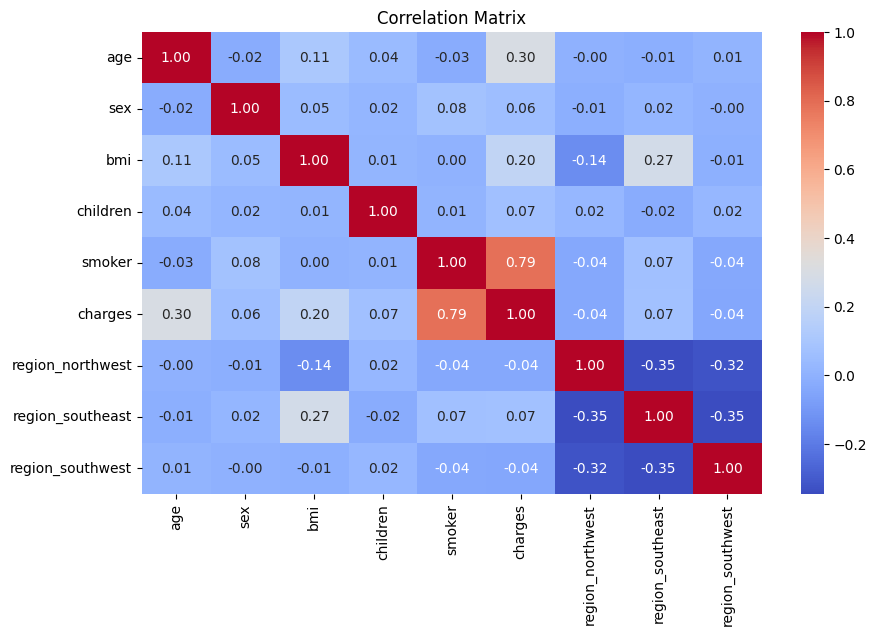

In [13]:
plt.figure(figsize = (10, 6))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix')

plt.show()

From the above heatmap, we can infer that smoker and charges have a correlation of 0.79. This strong positive correlation indicates that being a smoker is associated with a higher insurance charge. Now, the correlation between regions and charges is very weak, this suggests that regions alone does not have a strong impact on insurance charges (same thing happens with sex).

- Most influential factors for charges are smoking, age, and BMI.
- Smoking might be the likely critical factor here.

I love doing Heatmaps, these are so useful. When I started working in pricing, I had some customer data that helped me generate a heatmap that showed that month people complained the most due to high shippping costs.

In [18]:
# X.dtypes

,0
age,int64
sex,int64
bmi,float64
children,int64
smoker,int64
region_northwest,bool
region_southeast,bool
region_southwest,bool


After the hot one ecoding, the regions were stored as booleans. We need to change that. We need to transform these values into numeric values so they can be fed into the model:

In [5]:
X = df.drop(columns=['charges']) # features
X = X.astype({col: 'int' for col in X.select_dtypes(include=['bool']).columns}) # converting into integers

y = df['charges'] # target

X = sm.add_constant(X) # adding a constant for the regression (intercept)
                      # this will improve flexibility and interpertability (baseline representation)

model = sm.OLS(y, X).fit()

In [7]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:15:35   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

Summary interpretation:

- The most important predictors are smoker, age, bmi, and region (with the SE and SW having lower charges)
- Sex and the Northwest region do not have a statistically significant effect on charges.
- Smoking has the largest impact on charges, followed by age and BMI

### Visualization - Results Performance

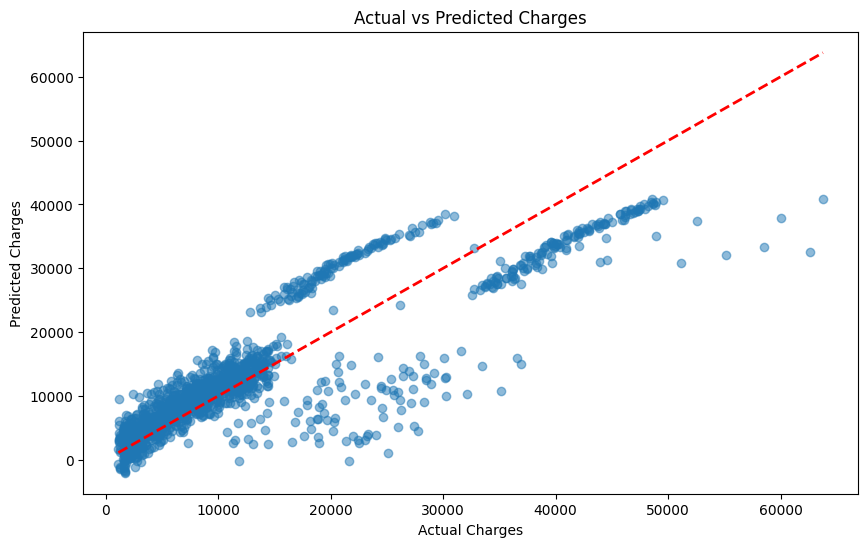

In [8]:
predicted_charges = model.predict(X)

plt.figure(figsize = (10, 6))
plt.scatter(y, predicted_charges, alpha = 0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth = 2)  # adding aerd line for perfect prediction
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')

plt.show()

The above visualization shows the following:

- Seems to perform well for lower and mid range charges but struggles with high changes, potentially due to the presence of outliers or some non linear relationship within the dataset. So our model needs improvements!

## Non Linear Models - Improvements

The above linear regression model might not be able to capture the complex patterns and non linear relationships of the data. Let's try and switch over to a non linear model that could be better suited for handling outliers and cplex patterns.

In [3]:
# Creating my own SKlearn estimator -> Applied aMachine Learning
# We to create our own estimators back in Professors Shanahan class

class InteractionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.array(X)
        bmi_index = 1  # replacing with actual index of 'bmi' after preprocessing
        smoker_index = 4  # replacing with actual index of 'smoker' after encoding
        bmi_smoker_interaction = X[:, bmi_index] * X[:, smoker_index]

        return np.hstack([X, bmi_smoker_interaction.reshape(-1, 1)])

In [4]:
df['log_charges'] = np.log(df['charges'])  # Log transform of the target variable

X = df.drop(columns=['charges', 'log_charges']) # features
y = df['log_charges'] # targets

Notes from my Applied Machine Learning Notebook:

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 42) # random state 42
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 42) # random state 42

# good practice -> prepare for pipelines
num_features = ['age', 'bmi', 'children'] # numerical
cat_features = ['sex', 'smoker', 'region'] # categorucal

In [6]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)]) # categorical to numerical (making it more user friendly for the model)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('interactions', InteractionTransformer()),
    ('model', GradientBoostingRegressor(random_state = 42))  # our place holder
])

In [7]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('interactions', InteractionTransformer()),
                ('model', GradientBoostingRegressor(random_state=42))])

In [8]:
X_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [9]:
param_grid = [
    {
        'model': [GradientBoostingRegressor(random_state = 42)],
        'model__n_estimators': [100, 200], # always play with these numbers, that's how we used to do it back in class
        'model__learning_rate': [0.05, 0.1], # same with learning rate
        'model__max_depth': [3, 4] # and depth and splits
    },
    {
        'model': [RandomForestRegressor(random_state = 42)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 10, None],
        'model__min_samples_split': [2, 5]
    }
]

# using gridsearch cv
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs = -1) # setting n_jobs = -1
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('interactions',
                                        InteractionTransformer()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'model': [GradientBoostingRegressor(random_state=42)],
                          'model__learning_rate': [0.05, 0.1],
                          'model__max_depth': [3, 4],
                          'model__n_estimators': [100, 200]},
                         {'model': [RandomForestRegressor(random_state=42)],
                          'model__max_depth': [5, 10, None],
                          'model__min_samples_split': [2, 5],
                          'model__n_estimators': [100, 200]}],
             scoring='neg_mean_squared_error')

In [10]:
best_model = grid_search.best_estimator_
print("Best model parameters:", grid_search.best_params_)

Best model parameters: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


In [11]:
# We can visualize accuracies to see how the model behaves
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val) # using a validaton set is always a good idea
y_test_pred = best_model.predict(X_test)

Convert predictions back to original scale (since we applied log transform)

In [12]:
y_train_pred_exp = np.exp(y_train_pred)
y_val_pred_exp = np.exp(y_val_pred)
y_test_pred_exp = np.exp(y_test_pred)

y_train_exp = np.exp(y_train)
y_val_exp = np.exp(y_val)
y_test_exp = np.exp(y_test)

# calculating RMSE for each set
train_rmse = np.sqrt(mean_squared_error(y_train_exp, y_train_pred_exp))
val_rmse = np.sqrt(mean_squared_error(y_val_exp, y_val_pred_exp))
test_rmse = np.sqrt(mean_squared_error(y_test_exp, y_test_pred_exp))

In [13]:
print('Training RMSE: ', train_rmse)

Training RMSE:  4311.5797190474095


In [14]:
print('Training RMSE: ', val_rmse)

Training RMSE:  4562.84787798061


In [15]:
print('Training RMSE: ', test_rmse)

Training RMSE:  3697.218124145299


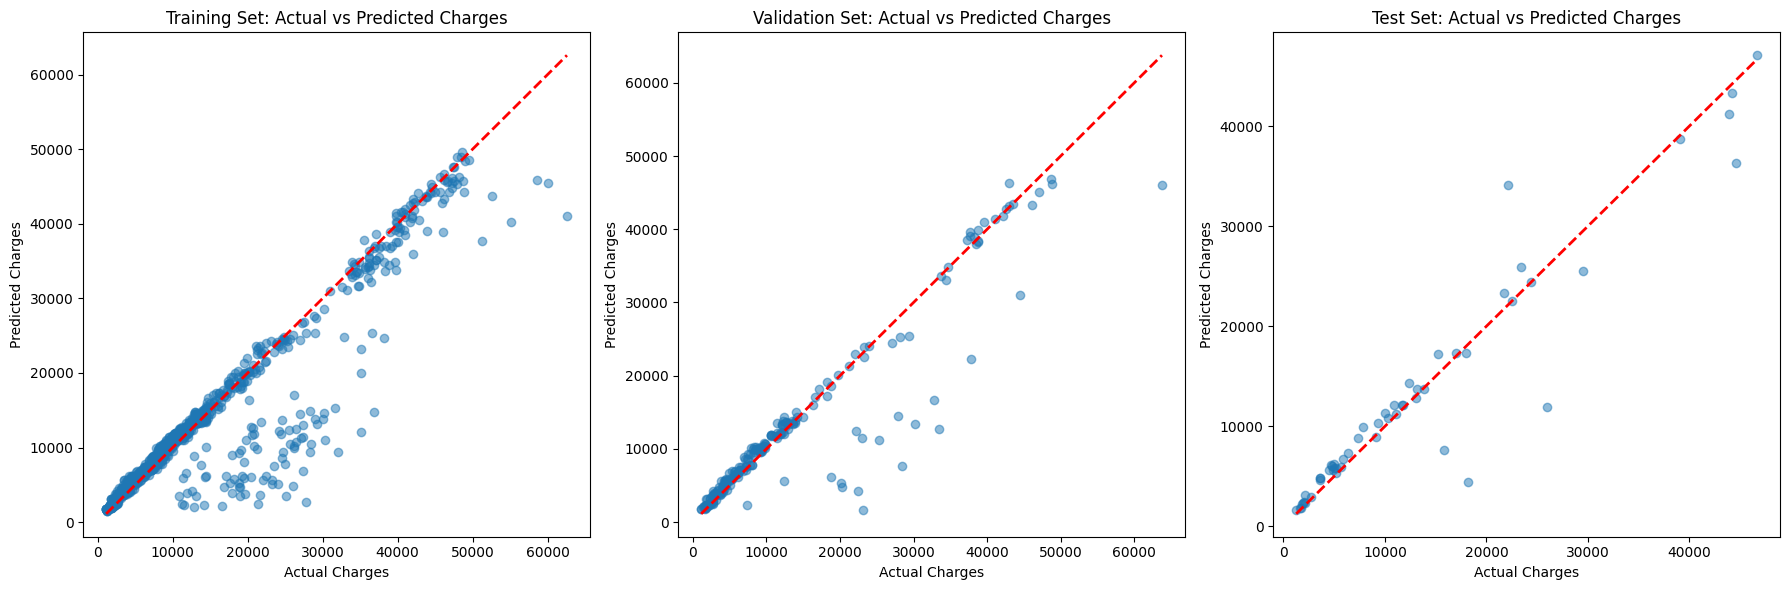

In [17]:
# using my data visualization homework notes
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

# training
axes[0].scatter(y_train_exp, y_train_pred_exp, alpha = 0.5)
axes[0].plot([y_train_exp.min(), y_train_exp.max()], [y_train_exp.min(), y_train_exp.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Charges')
axes[0].set_ylabel('Predicted Charges')
axes[0].set_title('Training Set: Actual vs Predicted Charges')

# validation
axes[1].scatter(y_val_exp, y_val_pred_exp, alpha = 0.5)
axes[1].plot([y_val_exp.min(), y_val_exp.max()], [y_val_exp.min(), y_val_exp.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual Charges')
axes[1].set_ylabel('Predicted Charges')
axes[1].set_title('Validation Set: Actual vs Predicted Charges')

# test
axes[2].scatter(y_test_exp, y_test_pred_exp, alpha = 0.5)
axes[2].plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', linewidth=2)
axes[2].set_xlabel('Actual Charges')
axes[2].set_ylabel('Predicted Charges')
axes[2].set_title('Test Set: Actual vs Predicted Charges')


plt.tight_layout()
plt.show()

The best model parameter where:
- Best model parameters: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

Our model using SKlearn seems to have captured non linear relationships better, giving better prediction accuracy. Training and Validation are RMSE are closely together, meaning the model is generalzing well to unseen data and is not overfitting. This is something I always like to measure even using vsiualizations. It's a bit unpextec that the RMSE of 3697.22 is both lower than the Training and Validation RMSE. Maybe more tunning is needed*. Maybe more fine tunning, cross validation, other implementations I don't really know, I don't want to get to crazy here.

# Step 3 - Non Parametric Statistics

## Decision Trees

Going back after our Statsmodel performance, a decisionn tree regression observes features of an object and trains a model in the structure of a tree to predict data in the future to predice meaningful continous output.



In [16]:
X = df.drop(columns=['charges'])  # features
y = df['charges'] # target

# let's split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

tree_model = DecisionTreeRegressor(max_depth = 4, random_state = 42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

# calcularting mae and R square
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [10]:
print('Mean Absolute Error:', mae)
print('R Squared: ', r2)

Mean Absolute Error: 2697.765430538481
R Squared:  0.8641310379678357


- MAE -> Is the AVG absolute difference between the predicted and actual insruance charges.

- R Sqaured -> 86% of the variance in insurnace charges.

In [11]:
# Feature Importance
feature_importance = tree_model.feature_importances_
features = X.columns
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_imp_df = feature_imp_df.sort_values(by = 'Importance', ascending = False)

feature_imp_df

,Feature,Importance
4,smoker,0.703212
2,bmi,0.178707
0,age,0.114492
3,children,0.003589
1,sex,0.000000
5,region_northwest,0.000000
6,region_southeast,0.000000
7,region_southwest,0.000000


As the above dataframe shows, Smoker has an importance score of 0.7. This is by far de the most important or critical feature in predicting insurance charges (this is something we also identify while generating the heatmap, which supports our previous regression model findings). The second most important are the BMI and Age columns. Let's visualize the Decision Tree below:

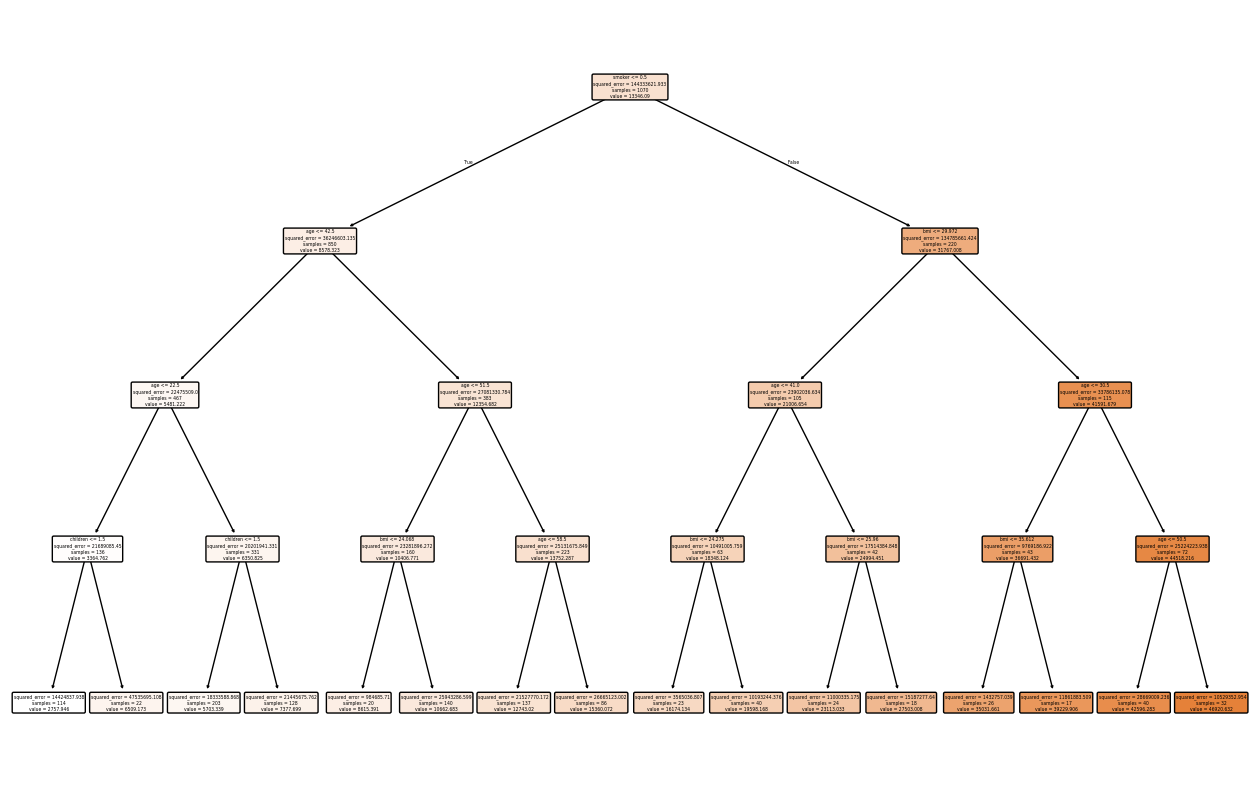

In [12]:
plt.figure(figsize = (16, 10))
plot_tree(tree_model, feature_names = features, filled = True, rounded = True)

plt.show()

## PCA - Dimensionality Reduction

In [18]:
X_standardized = StandardScaler().fit_transform(X) # very importnat, we need to standardize the data before PCA

Cool "pca.explained_variance_ratio.cumsum()" explanation: https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

converting components into DF: https://medium.com/@denizgunay/principal-component-analysis-pca-d8edf2bb6620

In [19]:
pca = PCA(n_components = None)  # Keep all components initially to analyze variance explained
X_pca = pca.fit_transform(X_standardized)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': cumulative_variance})

In [20]:
variance_df # explained variance by each principal component

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.192168,0.192168
1,PC2,0.165868,0.358036
2,PC3,0.137013,0.495049
3,PC4,0.132778,0.627827
4,PC5,0.119362,0.747188
5,PC6,0.115792,0.862980
6,PC7,0.097785,0.960766
7,PC8,0.039234,1.000000


The cumulative variance reaches 96% indicating that the first 7 components capture over 95% of the variance within the dataset.

In [21]:
n_components_95 = next(i for i, total in enumerate(cumulative_variance) if total >= 0.95) + 1
n_components_95

7

Now, we can use these 7 principal components instead of the original 8 features for any further implementation. I think this works kind of similar as the "bottle neck layer" of an AutoEncoder. If traine correctly, this bottle neck layer will hold the most important features.

# Observations:

- I really liked the "feature importance scores" process of the Decision Tree. With all these years doing multiple classification models, I never paid attention on how efficient decision trees can be. I've done PCA before for image recognition as well as AutoEncoders for neural networks. Now having the feature importance scores in mind, these can be kind of like a suplemental material to say "hey, these are the most important features within our company dataset that could help getting better predictions".

# Sources:

- Kaggle Data Source: https://www.kaggle.com/datasets/mirichoi0218/
insurance

- Heatmap: https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/

- Stats Model Geeks For Geeks: https://www.geeksforgeeks.org/linear-regression-in-python-using-statsmodels/

- dtypes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html

- Medium (Very Useful): https://medium.com/@deepml1818/python-statistical-modeling-linear-and-logistic-regression-with-statsmodels-124b3da9c30c

- Creating Estimator: https://sklearn-template.readthedocs.io/en/latest/user_guide.html

- GridSearchCV: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

- scatter: https://www.w3schools.com/python/matplotlib_scatter.asp

- scatter: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

- Gradient Boosting: https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm

- Random Forest: https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/

- RMSE: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html

- RMSE: https://www.geeksforgeeks.org/rmse-root-mean-square-error-in-matlab/

- Decision Tree Regressor: https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

- Understanding R Squared: https://www.investopedia.com/terms/r/r-squared.asp

- Decision tree Regressor: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html

- More Decison Tree: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

- MAE: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html

- Understanding MAE in Regression: https://medium.com/@m.waqar.ahmed/understanding-mean-absolute-error-mae-in-regression-a-practical-guide-26e80ebb97df

- R Squared: https://www.geeksforgeeks.org/how-to-calculate-r2-with-scikit-learn/

- Understanding feature importance: https://www.geeksforgeeks.org/understanding-feature-importance-and-visualization-of-tree-models/

- Feature Importance: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

- PCA: https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

- PCA SKlearn: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html

- PCA Components: https://codingnomads.com/sklearn-pca-parameters-attributes

- StackOverflow: https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

- PCA components: https://medium.com/@denizgunay/principal-component-analysis-pca-d8edf2bb6620

- PCA: https://www.ibm.com/topics/principal-component-analysis#:~:text=Two%20major%20components%20are%20calculated,second%20principal%20component%20(PC2).&text=The%20first%20principal%20component%20(PC1)%20is%20the%20direction%20in%20space,shape%20of%20the%20projected%20points.